# DATA ANALYSIS (PANDAS), VISUALIZATION (MATPLOTLIB), AND OPTIMIZATION (CVXPY) using daily stock prices

# 1. Some work with the data.

<Figure size 432x288 with 0 Axes>

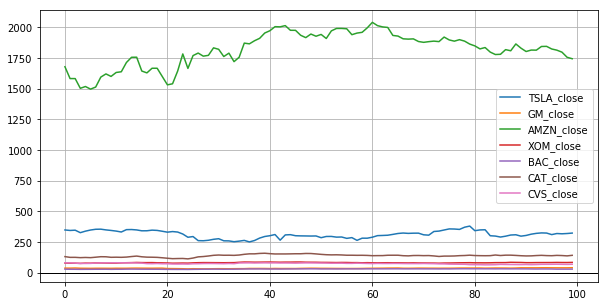

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

dstocks = pd.read_csv('Stocks-closeP.csv')
plt.figure()
dstocks.plot(grid = True, figsize = [10,5]).axhline(y = 0, color = "black", lw = 1)
plt.show()

# Compute and visualize growth rates of prices (from one day to the next)

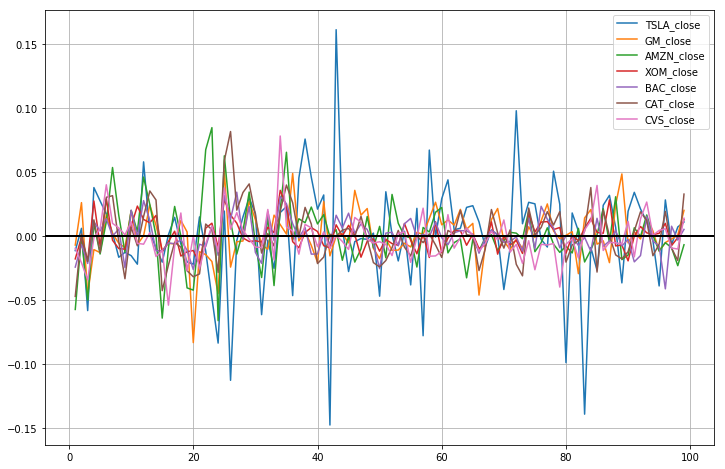

In [32]:
stock = dstocks.iloc[:,[1,2,3,4,5,6,7]] # Select colum 1-7 from the DataFrame

#Compute growth rates of that stock as [p2-p1]/p1
# A lambda function is applied locally
stock_change = stock.apply(lambda x: ((x - (x.shift(1))) / (x.shift(1))))

# Plot the dataframe of growth rates
stock_change.plot(grid = True, figsize = (12,8)).axhline(y = 0, color = "black", lw = 2)
# Then save the figure as a pdf file
plt.savefig('sample.pdf')

In [7]:
stock_change.describe()

,TSLA_close,GM_close,AMZN_close,XOM_close,BAC_close,CAT_close,CVS_close
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.000155,0.001015,0.000696,0.000718,0.000231,0.001008,-0.001496
std,0.042718,0.019532,0.025106,0.011800,0.013490,0.021610,0.017035
min,-0.147827,-0.083356,-0.066195,-0.021960,-0.041303,-0.047182,-0.054044
25%,-0.014031,-0.008151,-0.011595,-0.007480,-0.007619,-0.014010,-0.009980
50%,0.003731,0.000000,-0.000152,0.000000,-0.000360,0.000282,-0.003629
75%,0.022072,0.012741,0.011451,0.007688,0.007642,0.015367,0.006020
max,0.161461,0.051047,0.084830,0.035784,0.034332,0.081778,0.078289


In [8]:
#Extract the means
stock_means = stock_change.describe().iloc[1].values
stock_means

array([ 0.00015476,  0.00101455,  0.00069614,  0.00071825,  0.00023117,
        0.00100803, -0.00149629])

In [10]:
# Make covariance matrix
stock_var = stock_change.cov()

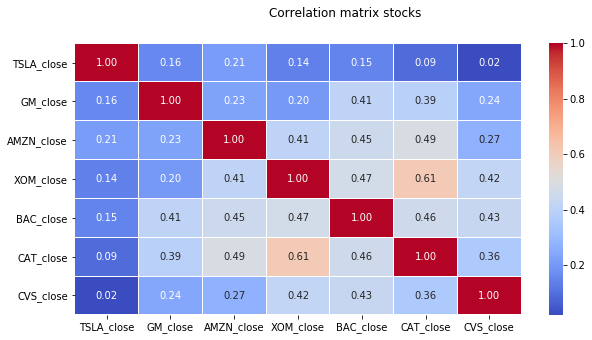

In [11]:
# Correlations matrix prettyfied

import seaborn as sns

f, ax = plt.subplots(figsize=(10, 5))
corr = stock_change.corr()
sns.heatmap(round(corr,2), annot=True,  ax=ax, cmap = "coolwarm", fmt='.2f', linewidths=.05)
t = f.suptitle('Correlation matrix stocks', fontsize=12)

# 2. Optimal Portfolio

In [27]:
import numpy as np
from cvxpy import *

Sigma = stock_var
mu = stock_means

w = Variable(7) # Decision variable
#w2 = Variable()
#w3 = Variable()
#w4 = Variable()
#w5 = Variable()

gamma = Parameter(nonneg=True) # Risk Parameter in the utility function
ret = mu*w
risk = quad_form(w, Sigma)

obj = Maximize(ret - gamma*risk)
constraints = [sum(w) == 1 , w >=0]

# Form the problem
prob = Problem(obj, constraints)

In [28]:
port_data = []
ret_data = []
risk_data = []
prob_data = []

gamma_vals = [2,5,10]
for i in range(3):
    gamma.value = gamma_vals[i]
    prob.solve() # Solve the problem for a specific value of gamma
    risk_data.append(sqrt(risk).value) # optimal value of the risk (standard deviation)
    ret_data.append(ret.value) # optimal value of the return
    prob_data.append(prob.value) # maximum utility
    port_data.append(w.value)  

In [29]:
port_data

[array([1.62608677e-09, 3.74466921e-01, 7.64480136e-09, 5.60899780e-01,
        2.14518572e-09, 6.46332877e-02, 4.45811205e-10]),
 array([1.10772806e-08, 2.85742438e-01, 5.92389981e-08, 7.14257438e-01,
        2.25260200e-08, 2.83736879e-08, 2.53563940e-09]),
 array([2.10297390e-08, 2.32213959e-01, 6.32814852e-09, 7.04126304e-01,
        6.36597044e-02, 3.44717119e-09, 1.18322796e-09])]

In [30]:
# Present your results nicely

results = pd.DataFrame({'Portfolio':['TSLA', 'GM', 'AMZN', 'XOM', 'BAC', 'CAT', 'CVS'], 'Risk Coeff 2':port_data[0], 'Risk Coeff 5':port_data[1], 'Risk Coeff 10':port_data[2]})
results

,Portfolio,Risk Coeff 2,Risk Coeff 5,Risk Coeff 10
0,TSLA,1.626087e-09,1.107728e-08,2.102974e-08
1,GM,3.744669e-01,2.857424e-01,2.322140e-01
2,AMZN,7.644801e-09,5.923900e-08,6.328149e-09
3,XOM,5.608998e-01,7.142574e-01,7.041263e-01
4,BAC,2.145186e-09,2.252602e-08,6.365970e-02
5,CAT,6.463329e-02,2.837369e-08,3.447171e-09
6,CVS,4.458112e-10,2.535639e-09,1.183228e-09
